In [1]:
import pandas as pd

filepath1 = './../data/dataset_site_info.parquet'
df1 = pd.read_parquet(filepath1)

df1 = df1[df1['tier'] == 'AODSIM']


In [2]:
from cmSim.utils import merge_pwgs_in_dataframe

filepath2 = './../data/dataset_size_info_complete.parquet'
df2 = pd.read_parquet(filepath2)

df2 = df2[df2['tier'] == 'AODSIM']
df2 = merge_pwgs_in_dataframe(df2)


In [3]:
dataframes = []

dataset_names = set(df1['dataset_name']) & set(df2['d_dataset'])
df2_idx_by_name = df2.set_index('d_dataset')

for name, df in df1.groupby('dataset_name'):
    df['pwg'] = df2_idx_by_name.loc[name]['pwg'] if name in dataset_names else 'None'
    dataframes.append(df)


In [4]:
df = pd.concat(dataframes)
df.sort_index(inplace=True)

df.head(None)


,dataset_name,dataset_id,replica_time_create,node_name,rep_size,min_time,max_time,br_user_group_id,tier,pwg
2,/GluGluToContinToZZTo2mu2nu_13TeV_MCFM701_pyth...,1114967,20200113,T2_FI_HIP,2.060427e+11,2020-01-14,2020-04-29,42.0,AODSIM,HIG
3,/WJetsToLNu_HT-70To100_TuneCP5_13TeV-madgraphM...,1247050,20200323,T2_US_Caltech,1.034198e+13,2020-03-23,2020-05-05,22.0,AODSIM,SUS
5,/SMS-T2bt-LLChipm_ctau-200_mLSP-1400_TuneCUETP...,1397254,20190925,T2_DE_DESY,1.866242e+11,2019-09-26,2020-12-31,22.0,AODSIM,SUS
7,/DYJetsToMuMu_M-50_TuneCP5_14TeV-madgraphMLM-p...,1560259,20200524,T1_RU_JINR_Disk,1.618496e+12,2020-06-06,2020-09-29,18.0,AODSIM,TRK
8,/DYJetsToTauTau_ForcedMuDecay_M-50_TuneCP5_13T...,1106693,20181003,T2_FR_IPHC,5.941757e+11,2019-01-01,2019-02-13,42.0,AODSIM,HIG
...,...,...,...,...,...,...,...,...,...,...
1268205,/GluGluHToWWToLNuQQ_M140_NNPDF31_TuneCP5_PSwei...,1353747,20190611,T2_FR_IPHC,4.005138e+09,2019-06-12,2019-06-26,18.0,AODSIM,HIG
1268206,/ggZH_HToGG_ZToNuNu_M125_13TeV_powheg_pythia8_...,1307530,20190402,T1_US_FNAL_Disk,1.705961e+09,2019-04-03,2019-04-09,18.0,AODSIM,HIG
1268207,/ST_tW_top_5f_NoFullyHadronicDecays_13TeV_PSwe...,1332017,20190506,T2_BE_UCL,5.500226e+08,2019-05-06,2019-07-12,18.0,AODSIM,TOP
1268208,/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_T...,1573739,20200724,T2_US_Wisconsin,8.395474e+10,2020-09-30,2020-10-01,NaN,AODSIM,EGM


In [5]:
from cmSim.config.pwgs import PWGs, PWGs_TO_MERGE

pags = list(PWGs['PAGs'].keys())
for pwg in PWGs_TO_MERGE:
    if pwg in pags:
        pags.remove(pwg)
if 'None' not in pags:
    pags.append('None')

print(pags)


['SMP', 'TOP', 'BPH', 'HIG', 'SUS', 'EXO', 'HIN', 'B2G', 'None']


In [6]:
from datetime import date
from cmSim.utils import get_country_by_site

date = date(2020, 12, 31)
df = df[(df['min_time'] <= date) & (date <= df['max_time'])]

df['country'] = df['node_name'].apply(get_country_by_site)
countries = list(set(df['country']))

print(countries)


['Switzerland', 'Malaysia', 'Turkey', 'Greece', 'Hungary', 'Austria', 'Italy', 'Estonia', 'South Korea', 'China', 'India', 'Belgium', 'Russia', 'USA', 'Finland', 'Brazil', 'Taiwan', 'Portugal', 'France', 'Germany', 'Poland', 'Spain', 'Pakistan', 'Ukraine', 'United Kingdom']


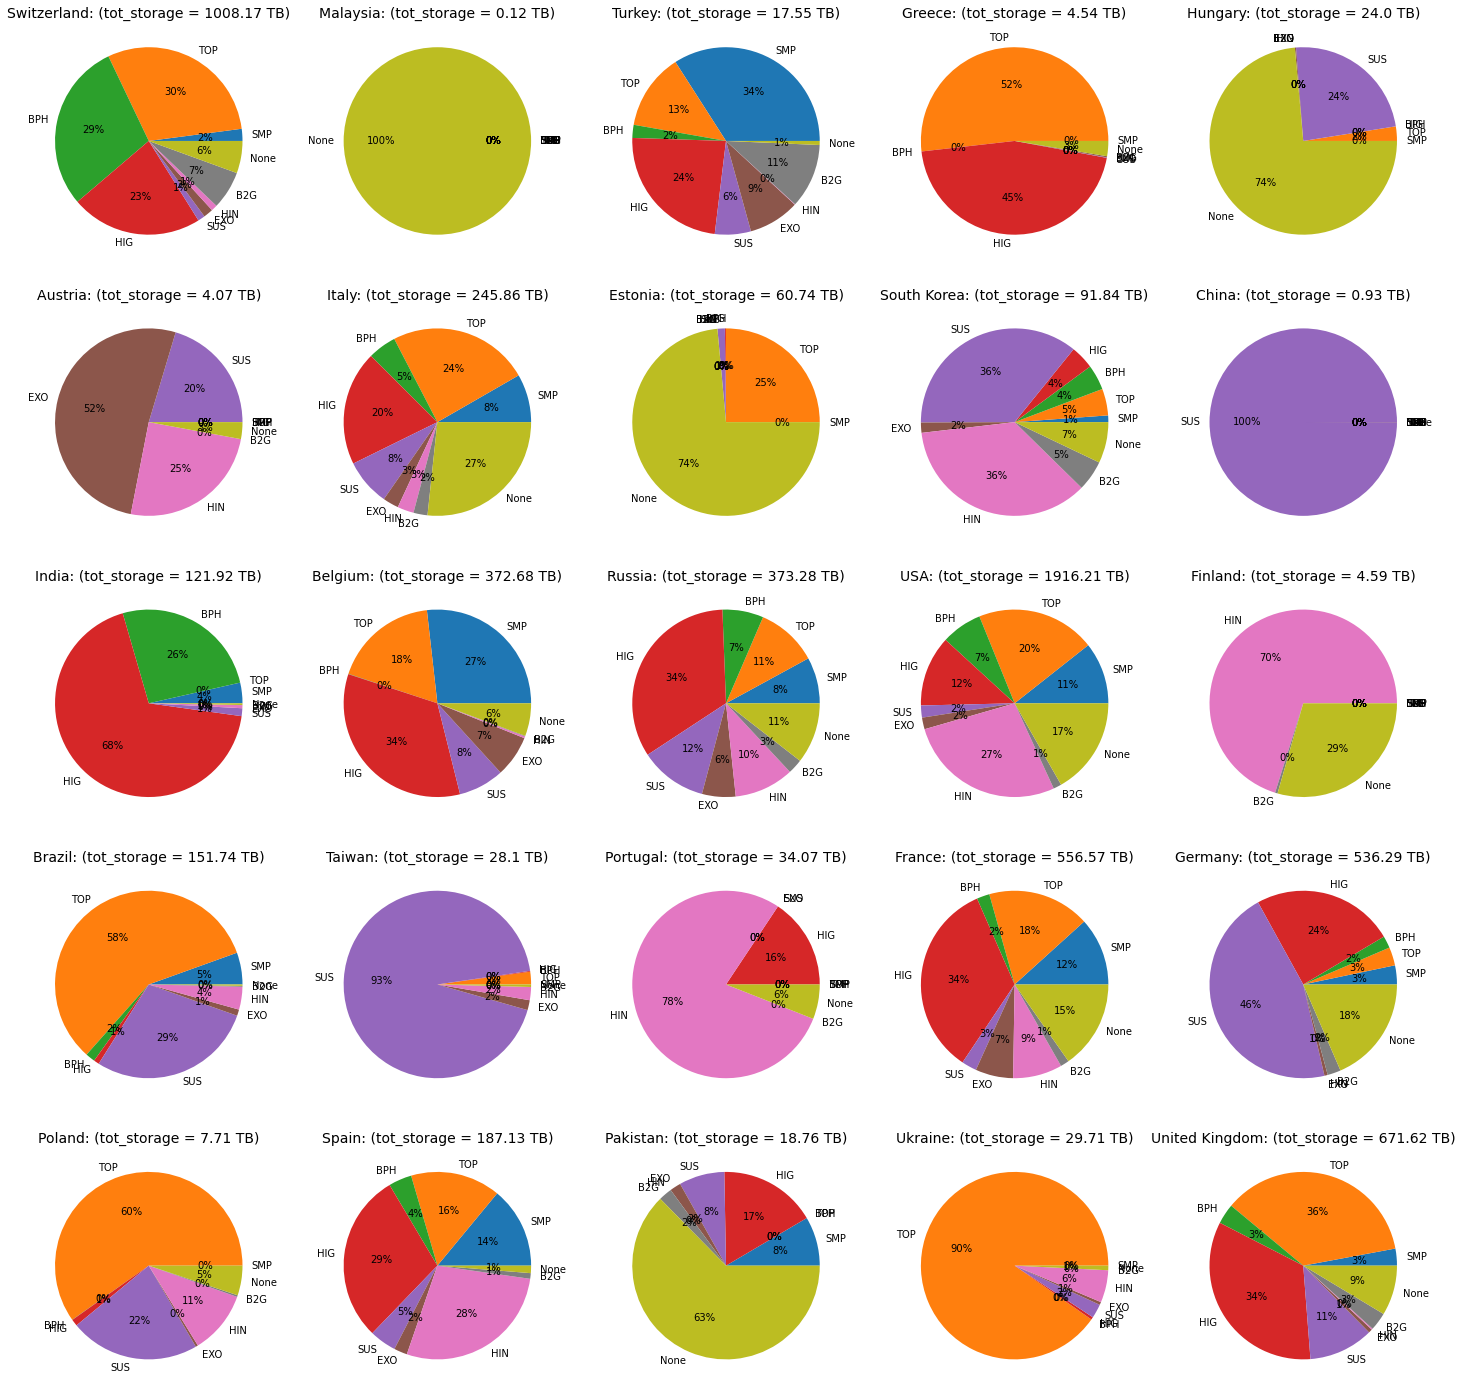

In [7]:
import pylab as plt

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(25, 25))
axs = axs.ravel()

for i, country in enumerate(countries):
    country_df = df[df['country'] == country]
    tot_size = round(country_df['rep_size'].sum() / 1e12, 2)
    data = [country_df[country_df['pwg'] == pag]['rep_size'].sum()
            for pag in pags]
    axs[i].pie(data, labels=pags, autopct='%1.0f%%', normalize=True)
    title = f'{country}: (tot_storage = {tot_size} TB)'
    axs[i].set_title(title, fontsize=14)

fig.savefig('./../data/country_storage_by_pag.png')
